In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from tqdm import tqdm

from models import TextClassificationModel, zip_ssl
from datasets import AGNEWS
from utils import train, eval, pearson, acc, nomean, pearson_delta

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
EPOCHS = 30
LR = 1e-3
BATCH_SIZE = 2048
EMBED_DIM = 64

In [63]:
ds = AGNEWS()

In [5]:
# train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE)
# model = TextClassificationModel(embed_dim = EMBED_DIM).to(device)

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = LR)

In [6]:
# log = []
# for epoch in tqdm(range(EPOCHS)):
#     loss_train = train(model, train_loader, criterion, optimizer)
#     loss_eval = eval(model, val_loader, criterion)
#     # print(loss_train, loss_eval)
#     log.append([loss_train, loss_eval])
# plt.plot(log);
# eval(model, test_loader, criterion), acc(model, test_loader)

In [7]:
train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE, ssl = True)
model = zip_ssl(embed_dim = EMBED_DIM).to(device)

# criterion = pearson
# criterion = nomean
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LR)

In [8]:
log = []
for epoch in tqdm(range (EPOCHS)):
    loss_train = train(model, train_loader, criterion, optimizer, ssl = True)
    loss_eval = eval(model, val_loader, criterion, ssl = True)
    corr = eval(model, val_loader, pearson_delta, ssl = True)
    print(loss_train, loss_eval, corr)
    log.append([loss_train, loss_eval])

  3%|▎         | 1/30 [00:08<04:18,  8.92s/it]

2.308284576263344e-05 1.0371138031284014e-05 0.00011861032495896022


  7%|▋         | 2/30 [00:17<04:03,  8.71s/it]

1.1032447815268187e-05 1.012185774743557e-05 0.0001029937465985616


 10%|█         | 3/30 [00:26<03:52,  8.63s/it]

1.0512130580058223e-05 9.006561400989691e-06 8.62142393986384e-05


 13%|█▎        | 4/30 [00:34<03:43,  8.59s/it]

1.06876138189252e-05 8.66182055324316e-06 9.792255361874898e-05


 17%|█▋        | 5/30 [00:43<03:34,  8.58s/it]

1.0243423977507311e-05 1.3884142351647218e-05 8.268699670831362e-05


 20%|██        | 6/30 [00:51<03:26,  8.59s/it]

9.431098939099333e-06 8.674932643771172e-06 9.076176087061564e-05


 23%|██▎       | 7/30 [01:00<03:16,  8.56s/it]

9.669811015523839e-06 8.870085080464682e-06 9.124745676914851e-05


 27%|██▋       | 8/30 [01:08<03:07,  8.54s/it]

8.557921553259357e-06 8.18716703603665e-06 8.036806186040242e-05


 30%|███       | 9/30 [01:17<02:59,  8.53s/it]

8.967978626554995e-06 7.333790883421898e-06 0.0001332991470893224


 33%|███▎      | 10/30 [01:25<02:50,  8.53s/it]

8.934659344193182e-06 1.3574584387242794e-05 2.09486981232961e-05


 37%|███▋      | 11/30 [01:34<02:42,  8.54s/it]

9.848047905650578e-06 7.949749007821082e-06 8.012062311172485e-05


 40%|████      | 12/30 [01:42<02:33,  8.55s/it]

9.1917596659378e-06 1.0857013675073782e-05 9.189106027285258e-05


 43%|████▎     | 13/30 [01:51<02:25,  8.55s/it]

8.146803074500017e-06 8.146674837917089e-06 8.305348952611288e-05


 47%|████▋     | 14/30 [02:00<02:16,  8.55s/it]

7.99239796112504e-06 1.0465928042928378e-05 4.405624916156133e-05


 50%|█████     | 15/30 [02:08<02:08,  8.56s/it]

7.999345513158722e-06 1.0494784452021122e-05 3.079930692911148e-05


 53%|█████▎    | 16/30 [02:17<01:59,  8.55s/it]

7.830462769784949e-06 7.298231745759646e-06 6.399987017114957e-05


 57%|█████▋    | 17/30 [02:25<01:51,  8.57s/it]

7.975208630229821e-06 7.75551392386357e-06 7.747021690011025e-05


 60%|██████    | 18/30 [02:34<01:42,  8.56s/it]

8.122755034843035e-06 9.795203960190217e-06 4.305917769670487e-05


 63%|██████▎   | 19/30 [02:42<01:34,  8.55s/it]

7.804436445759053e-06 6.9921012036502364e-06 5.810815840959549e-05


 67%|██████▋   | 20/30 [02:51<01:25,  8.54s/it]

7.985037514580446e-06 1.1377543831864993e-05 5.8697056025266644e-05


 70%|███████   | 21/30 [02:59<01:16,  8.53s/it]

7.475105579942465e-06 9.162531234323978e-06 3.7719900409380596e-05


 73%|███████▎  | 22/30 [03:08<01:08,  8.53s/it]

6.6523920793674495e-06 1.1618566078444322e-05 5.293585111697515e-05


 77%|███████▋  | 23/30 [03:16<00:59,  8.55s/it]

7.588333821969858e-06 7.550885900855065e-06 3.556274498502413e-05


 80%|████████  | 24/30 [03:25<00:51,  8.54s/it]

8.41369451709876e-06 8.912856845806042e-06 0.00010004250456889471


 83%|████████▎ | 25/30 [03:33<00:42,  8.54s/it]

6.847158491023277e-06 8.778883454700312e-06 2.0104389327267805e-05


 87%|████████▋ | 26/30 [03:42<00:34,  8.54s/it]

7.0118950230575965e-06 6.898239565392335e-06 7.858533163865407e-05


 90%|█████████ | 27/30 [03:51<00:25,  8.53s/it]

6.039924486621953e-06 5.6248203230400884e-06 4.510792468984922e-05


 93%|█████████▎| 28/30 [03:59<00:17,  8.53s/it]

6.218605556345561e-06 1.0045664384961129e-05 2.549067853639523e-05


 97%|█████████▋| 29/30 [04:08<00:08,  8.55s/it]

6.116618855709308e-06 8.688459483285745e-06 5.597184846798579e-05


100%|██████████| 30/30 [04:16<00:00,  8.56s/it]

6.414046694867705e-06 9.139353254189094e-06 2.7423148353894553e-05


In [9]:
import numpy as np
log = np.array(log)

(7.876629181402295e-06, 5.004689685608211e-05)

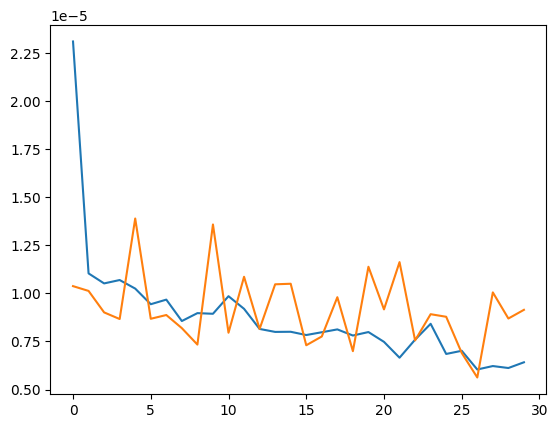

In [10]:
plt.plot(log);
eval(model, test_loader, criterion, ssl = True), eval(model, test_loader, pearson_delta, ssl = True)
# eval(model, test_loader, criterion, ssl = True)

In [12]:
for idx, (label, text, offsets) in enumerate(val_loader):
    btsz = len(offsets) // 2
    h = model.forward(text, offsets)
    delta = torch.nn.functional.pairwise_distance(h[:btsz], h[btsz:])
    loss = criterion(delta, label)
    break

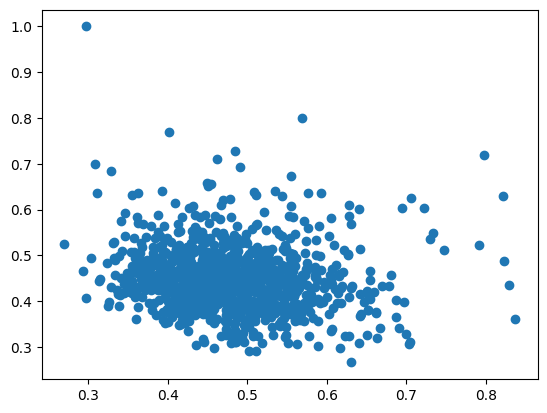

In [13]:
plt.scatter(delta.cpu().detach(), label.cpu().detach())

In [14]:
from sklearn.neighbors import KNeighborsClassifier
train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE, ssl = False)
final_htrain = []
final_labels = []
for idx, (label, text, offsets) in enumerate(train_loader):
    h = model(text, offsets).detach().cpu().numpy()
    final_htrain.append(h)
    final_labels.append(label.detach().cpu().numpy())
final_htrain = np.concatenate(final_htrain, axis=0)
final_labels = np.concatenate(final_labels, axis=0)

In [15]:
#create tensor placeholder and concatenate
h_test = []
labels_test = []
for idx, (label, text, offsets) in enumerate(test_loader):
    h = model.forward(text, offsets)
    h_test.append(h.detach().cpu().numpy())
    labels_test.append(label.detach().cpu().numpy())
#concatenate each position of final_h
final_htest = np.concatenate(h_test, axis = 0)
labels_test = np.concatenate(labels_test, axis = 0)

In [16]:
#fit knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(final_htrain, final_labels)
knn_pred = knn.predict(final_htest)
knn_pred_train = knn.predict(final_htrain)

In [17]:
#calculate accuracy
from sklearn.metrics import accuracy_score
print ("Accuracy for train is ", accuracy_score(final_labels, knn_pred_train))
print ("Accuracy for test is ", accuracy_score(labels_test, knn_pred))

Accuracy for train is  0.7258771929824561
Accuracy for test is  0.5671052631578948


# REPRODUCAO

In [71]:
from sklearn.neighbors import KNeighborsClassifier
train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE, ssl = True)
final_htrain = []
final_labels = []
y_train = []
for idx, (label, text, offsets, y) in enumerate(train_loader):
    final_labels.append(label)
    y_train.append(y.cpu().numpy())

#final_htrain = np.concatenate(final_htrain, axis=0)
final_labels = np.concatenate(final_labels, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [68]:
from sklearn.neighbors import KNeighborsClassifier
train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE, ssl = True)
final_labels_test = []
y_test = []
for idx, (label, text, offsets, y) in enumerate(test_loader):
    #print (label)
    final_labels_test.append(label)
    y_test.append(y.cpu().numpy())

#final_htrain = np.concatenate(final_htrain, axis=0)
final_labels_test = np.concatenate(final_labels_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [74]:
#calculate ncd of final_labels and calculate knn, as described in the algorithm from the paper
k=2
final_yhat = []
for x1 in tqdm(final_labels_test):
    c_x1 = len(gzip.compress(x1.encode('utf-8')))
    distance_from_x1 = []
    for x2 in (final_labels):
        c_x2 = len(gzip.compress(x2.encode('utf-8')))
        c_x1_x2 = len(gzip.compress((x1+x2).encode('utf-8')))
        distance_from_x1.append((c_x1_x2 - min(c_x1, c_x2)) / max(c_x1, c_x2))

    #calculate knn
    sorted_idx = np.argsort(distance_from_x1)
    topk_class = y_train[sorted_idx[:k]]
    yhat = np.argmax(np.bincount(topk_class))
    final_yhat.append(yhat)

#calculate accuracy
final_yhat = np.array(final_yhat)
from sklearn.metrics import accuracy_score

print("Accuracy: ", accuracy_score(y_test, final_yhat))
    

            


  0%|          | 32/7600 [03:06<12:16:19,  5.84s/it]